# Cat and Dog Linear Classification with CIFAR10
CIFAR10 is a classical image dataset that composed of 10 classes 32*32 color images. We are going to implement a simple linear classifier of cat and dog classes in CIFAR10.

## Data Preparation and Visualization

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import sys
# sys.path.append('/content/drive/MyDrive/HW3/')

In [3]:
# You may change `MODEL_DIR` to a existing local directory if you are not using Colab
MODEL_DIR = './'
MODEL_PATH = MODEL_DIR + 'model.pt' if MODEL_DIR.endswith('/') else MODEL_DIR + '/model.pt'

In [4]:
from _utils import load_data, Model_Tests, Loss_Test, Optimizer_Test, evaluate
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

c:\Users\Tim\Desktop\nsysu\class_deep_vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
  print(f'Using torch {torch.__version__}, device = {torch.cuda.get_device_name(0)}')
else:
  DEVICE = 'cpu'
  print(f'Using torch {torch.__version__}, device = cpu')

Using torch 1.13.1+cpu, device = cpu


In [6]:
images, labels, classes = load_data()

Files already downloaded and verified


In [7]:
print(f'Data type of images: {images.dtype} (value range: [{images.min()}, {images.max()}])')
print(f'Shape of images: {images.shape}')
print(f'Shape of labels: {labels.shape}')
print(f'Number of classes: {len(classes)}')
print(f'Classes: {classes}')

Data type of images: uint8 (value range: [0, 255])
Shape of images: (10000, 32, 32, 3)
Shape of labels: (10000,)
Number of classes: 2
Classes: ['cat', 'dog']


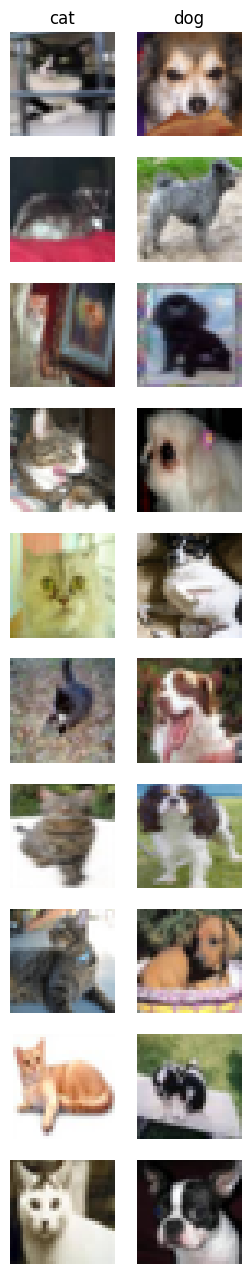

In [8]:
# Display samples of each class
plt.rcParams['figure.figsize'] = (3, 16)
num_classes = len(classes)
num_example = 10
for label, class_name in enumerate(classes):
  idxs = np.flatnonzero(labels == label)
  idxs = np.random.choice(idxs, num_example, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + label + 1
    plt.subplot(num_example, num_classes, plt_idx)
    plt.imshow(images[idx]); plt.axis('off')
    if i == 0:
      plt.title(class_name)
plt.show()

## Dataset and Dataloader
Dataset is a wrapper that loads data from a given file path. Since data loading is already done by downloading the dataset online, you only need to follow the directions below to put data into dataset. Datasets always need to have the following two methods implemented:

1. `__len__(self)`: A method that should simply calculate and return the number of data in the dataset. After it is implemented, you can simply call it with len(dataset).
2. `__getitem__(self, index)`: A method that should return the data with a given index from your dataset. Implementing this will allow you to access your dataset like a list, that is, you can then simply call dataset[9] to access the 10th image in the dataset.

For image data, we usually normalize the values to range from 0 to 1 for easier and faster computation. As the pixel values range from 0 to 255, dividing all the values by 255 will convert it to range from 0 to 1.

* Program comments:
1. every image is compised of 32*32*3 pixels. Convet it into one dimension array.
2. every pixel is a number between 0~255, so normalize it by dividing 255

In [9]:
class Dataset(object):
  def __init__(self, images, labels):
    self.images = None
    self.labels = None
    ####################
    # TODO:
    # 1. Flatten data, that is, change shape of images from (num_images, image_height, image_width, image_channel) to (num_images, flatten_data)
    # 2. Normalize data from range [0, 255] to range [0, 1], you should cast its type to np.float64 first
    # 3. Store flatten and normalized data in variable `self.images`
    # 4. Store labels in variable `self.labels`
    ####################
    # -----START OF YOUR CODE-----

    self.images = images.view().reshape(images.shape[0],-1)
    self.images = self.images / 255
    self.labels = labels

    # ------END OF YOUR CODE------
  def __len__(self):
    num_data = None
    ####################
    # TODO:
    # 1. Store the length of dataset, that is, the quantity of data in variable `num_data`
    ####################
    # -----START OF YOUR CODE-----

    num_data = self.images.shape[0]

    # ------END OF YOUR CODE------
    return num_data
  def __getitem__(self, idx):
    image = None
    label = None
    ####################
    # TODO:
    # 1. Store idx-th image in variable `image` and its label in variable `label`
    ####################
    # -----START OF YOUR CODE-----

    image = self.images[idx]
    label = self.labels[idx]
      
    # ------END OF YOUR CODE------
    return image, label

In [10]:
# Data splitting with numpy array slicing
num_data = images.shape[0]
split_ratio = {'train': 0.6, 'valid': 0.2, 'test': 0.2}
num_valid_data = round(num_data * split_ratio['valid'])
num_test_data = round(num_data * split_ratio['test'])
num_train_data = num_data - (num_valid_data + num_test_data)

start_idx = 0
train_dataset = Dataset(images[start_idx:start_idx+num_train_data], labels[start_idx:start_idx+num_train_data])
start_idx += num_train_data

valid_dataset = Dataset(images[start_idx:start_idx+num_valid_data], labels[start_idx:start_idx+num_valid_data])
start_idx += num_valid_data

test_dataset = Dataset(images[start_idx:start_idx+num_test_data], labels[start_idx:start_idx+num_test_data])

print(f'Number of training data: {len(train_dataset)}')
print(f'Number of validation data: {len(valid_dataset)}')
print(f'Number of test data: {len(test_dataset)}')

Number of training data: 6000
Number of validation data: 2000
Number of test data: 2000


Data type of original image: uint8 (value range: [11, 218])
Shape of original image: (32, 32, 3)
Data type of dataset image: float64 (value range: [0.043137254901960784, 0.8549019607843137])
Shape of dataset image: (3072,)



C:\Users\Tim\AppData\Local\Temp\ipykernel_15620\376918410.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


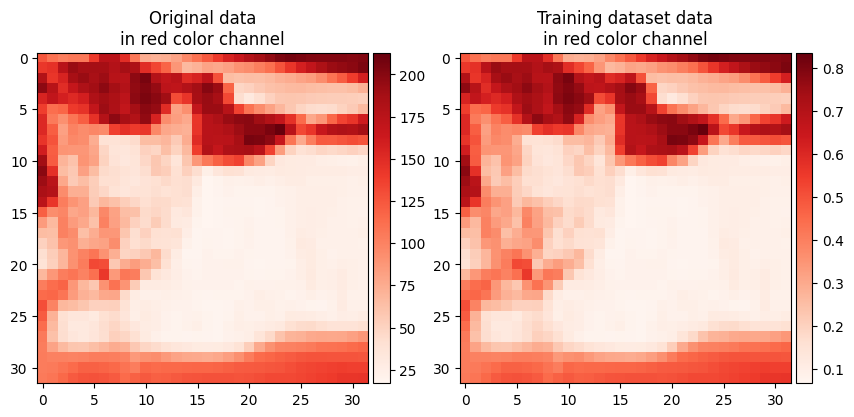

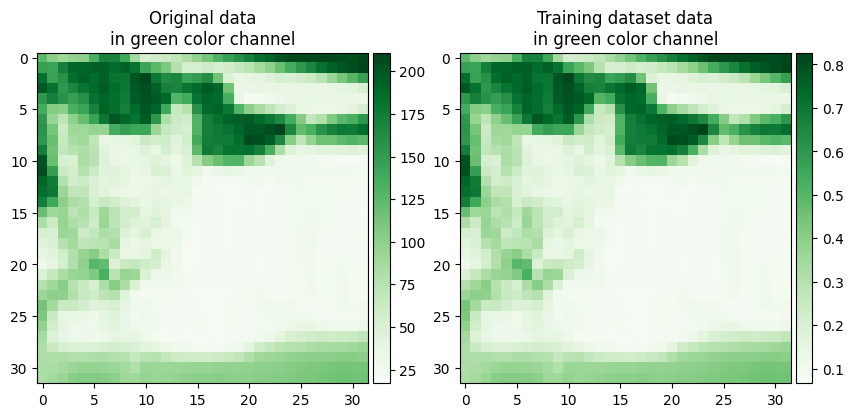

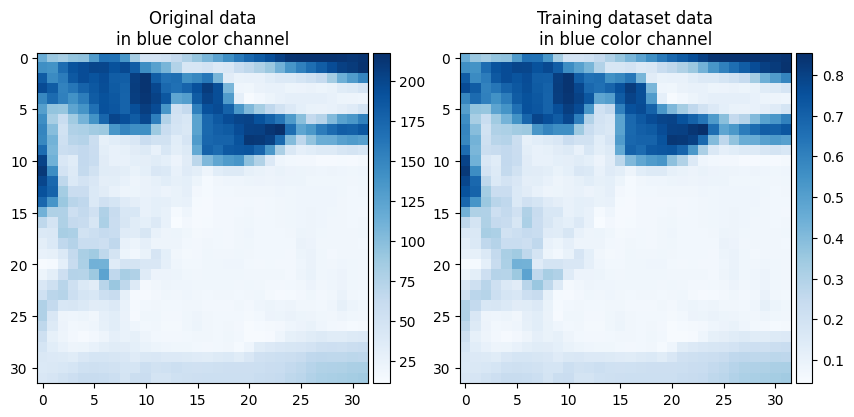

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (10, 5)

original_data = images[0]
train_data_img, train_data_label = train_dataset[0]
print(f'Data type of original image: {original_data.dtype} (value range: [{original_data.min()}, {original_data.max()}])')
print(f'Shape of original image: {original_data.shape}')
print(f'Data type of dataset image: {train_data_img.dtype} (value range: [{train_data_img.min()}, {train_data_img.max()}])')
print(f'Shape of dataset image: {train_data_img.shape}\n')
heigth, width, channel = original_data.shape
train_data_img = train_data_img.reshape(heigth, width, channel) # Reshape flatten data for visualization

for channel_idx, color_channel in enumerate(['red', 'green', 'blue']):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.set_title(f'Original data\nin {color_channel} color channel')
  img1 = ax1.imshow(original_data[:, :, channel_idx], cmap=f'{color_channel.capitalize()}s')
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(img1, cax=cax, orientation='vertical')

  ax2.set_title(f'Training dataset data\nin {color_channel} color channel')
  img2 = ax2.imshow(train_data_img[:, :, channel_idx], cmap=f'{color_channel.capitalize()}s')
  divider = make_axes_locatable(ax2)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(img2, cax=cax, orientation='vertical')

  fig.show()

DataLoader is another important data wrapper for machine learning. By wrapping a dataset in a dataloader, we will be able to load small subsets of the dataset at a time, instead of having to load each sample separately. In machine learning, the small subsets are referred to as mini-batches, which will play an important role later in the lecture.

* Program comment:
1. mini batch : To reduce running time, we split the entire dataset into multiple batches. This allows us to process smaller portions of data at a time.Batch length : $$\lceil NumOfData \div BatchSize \rceil$$

In [12]:
import math
class Dataloader(object):
  def __init__(self, dataset, batch_size=1):
    self.dataset = dataset
    self.indice = np.array(range(len(self.dataset))) 
    self.batch_size = batch_size
  def __len__(self):
    num_batch = None
    ####################
    # TODO:
    # 1. Store the number of batches in variable `num_batch`
    ####################
    # -----START OF YOUR CODE-----
    
    num_batch = math.ceil(len(self.dataset) / self.batch_size)
    
    # ------END OF YOUR CODE------
    return num_batch
  def __getitem__(self, idx):
    batch_data = self.dataset[self.indice[idx: idx+self.batch_size]]
    return batch_data
  def shuffle(self):
    np.random.shuffle(self.indice)

In [13]:
BATCH_SIZE = 16

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = Dataloader(valid_dataset, batch_size=BATCH_SIZE)

print(f'Number of batches in training dataloader: {len(train_dataloader)}')
print(f'Number of batches validation dataloader: {len(valid_dataloader)}')

Number of batches in training dataloader: 375
Number of batches validation dataloader: 125


## Linear Classifier
Let $\mathbf{x} \in \mathbb{R}^{N\times D}$ be flatten image data and $\mathbf{y} \in \mathbb{R}^{N}$ be labels, while $N$ and $D$ indicate the quantity of data and the length of flatten image data, which are $10000$ and $32*32*3=3072$ in our case.

Define the linear classifier $\mathbf{\hat{y}}=sigmoid(\mathbf{W}\mathbf{x})$ where $\mathbf{W} \in \mathbb{R}^{D}$ is the model weights. Since the sigmoid function $sigmoid(k)=\frac{1}{1+e^{-k}}$ squashs output to interval $[0, 1]$, its output can be seen as the probability of being either the label.

We usually use binary cross-entropy(BCE) loss for binary classification task, it can be formed like: $BCE(y,\hat{y})=-(y*log(\hat y)+(1-y)*log(1-\hat y))=L$.

The optimizer is used to update model weights with gradient descent, the new weights are calculated by $\mathbf{W}^{(t+1)}=\mathbf{W}^{(t)}-\alpha*\frac {\partial L}{\partial \mathbf{W}^{(t)}}$ where $\alpha$ is the learning rate. Gradient of weights can be obtained by chain rule: $\frac{\partial L}{\partial \mathbf{W}}=\frac{\partial L}{\partial \hat y}*\frac{\partial \hat y}{\partial \mathbf{W}}$

* Program comment:
1. The forward part of the neural network computes the result based on the activation function of each neuron. In this case, a single-layer neural network is used, and the calculation is as follows:  $sigmoid(\mathbf{W}\mathbf{x})$
2. The forward part of the neural network : $\frac{\partial L}{\partial \mathbf{W}}=\frac{\partial L}{\partial \hat y}*\frac{\partial \hat y}{\partial \mathbf{z}}*\frac{\partial z}{\partial w}$
    * $\frac{\partial L}{\partial \hat y} = -\frac{y}{\hat y} + \frac{1 - y}{1 - \hat y}$
    * $\frac{\partial \hat y}{\partial z} = {\hat y} * ({1 - \hat y})$
    * $\frac{\partial z}{\partial w} = {x}$
3. Finally, the optimization step updates the weights (W) : $\mathbf{W}^{(t+1)}=\mathbf{W}^{(t)}-\alpha*\frac {\partial L}{\partial \mathbf{W}^{(t)}}$

In [14]:
class LinearClassifier(object):
  def __init__(self, device='cpu'):
    self.W = None # classifier weights
    self.dv = device
  def save_weights(self, path):
    torch.save(self.W, path)
  def load_weights(self, path):
    self.W = torch.load(path)
  def sigmoid(self, score):
    prob = torch.zeros_like(score)
    ####################
    # TODO:
    # 1. Implement sigmoid function on `score` and store in variable `prob`
    ####################
    # -----START OF YOUR CODE-----

    prob = 1 / (1 + np.exp(-score))
    
    # ------END OF YOUR CODE------
    return prob
  def forward(self, x):
    num_data, data_dim = x.shape
    if self.W is None:
      np.random.seed(0)
      self.W = torch.from_numpy(np.random.randn(data_dim)*1e-4).to(self.dv)
    x = x.to(self.dv)
    pred_y = torch.zeros(num_data).to(self.dv)
    ####################
    # TODO:
    # 1. Implement linear classifier f(x) = W * x, and then transform the predicted values to probabilities by sigmoid function
    # 2. Store probabilities in variable `pred_y`
    ####################
    # -----START OF YOUR CODE-----

    pred_y = torch.matmul(self.W, x.transpose(0,1))
    pred_y = self.sigmoid(pred_y)
    
    # ------END OF YOUR CODE------
    self.cache = (x, pred_y)
    return pred_y
  def backward(self, dL):
    dL = dL.to(self.dv)
    dW = torch.zeros(1).to(self.dv)
    ####################
    # TODO:
    # 1. Derive the gradients of weights, calculate their average and store it in variable `dW`
    #   HINT 1: Chain rule d(loss)/d(weight) = d(loss)/d(pred_y) * d(pred_y)/d(weight)
    #   HINT 2: Use self.cache (batch flatten data x that multiplied weights in forward process, preditcted output that calculated by weights and input)
    ####################
    # -----START OF YOUR CODE-----

    dPred_y = self.cache[1] * (1 - self.cache[1])
    dZ = self.cache[0]
    dW = dL * dPred_y
    dW = torch.matmul(dW, dZ) / len(self.cache[0])
    
    # ------END OF YOUR CODE------
    return dW

class BCEloss(object):
  def __init__(self, device='cpu'):
    self.dv = device
  def __call__(self, y, pred_y):
    y = y.to(self.dv)
    pred_y = pred_y.to(self.dv)
    L = torch.zeros_like(y).to(self.dv)
    dL = torch.zeros_like(y).to(self.dv)
    ####################
    # TODO:
    # 1. Implement binary cross-entropy loss and store the results of each data in variable `L`
    # 2. Derive the gradient of binary cross-entropy loss and store the results of each data in variable `dL`
    ####################
    # -----START OF YOUR CODE-----
    
    L = -(y * np.log(pred_y) + (1 - y) * np.log(1 - pred_y))
    dL = -y / pred_y + (1 - y) / (1 - pred_y)

    # ------END OF YOUR CODE------
    return L, dL

class Optimizer(object):
  def __init__(self, model, learning_rate):
    self.model = model
    self.lr = learning_rate
  def step(self, dW):
    dW = dW.to(model.dv)
    new_weights = self.model.W.clone()
    ####################
    # TODO:
    # 1. Update model weights by gradient descent and store it in variable `new_weights`
    ####################
    # -----START OF YOUR CODE-----
    
    new_weights = self.model.W - self.lr * dW
    
    # ------END OF YOUR CODE------
    self.model.W = new_weights

In [15]:
model = LinearClassifier(DEVICE)
Model_Tests(model)

Result of sigmoid function with single value 0: Correct
Result of sigmoid function with all-zero array: Correct
Result of sigmoid function with single value 100: Correct
Result of sigmoid function with all-100 array: Correct
Result of forward: Correct
Result of backward: Expected -1.249252247115394 but got [-0.58300255 -0.66624969]


In [16]:
loss_func = BCEloss(DEVICE)
Loss_Test(loss_func)

Result of forward: Correct
Result of backward: Correct


In [17]:
optimizer = Optimizer(model, learning_rate=0.1)
Optimizer_Test(optimizer)

tensor([ 0.2002, -0.9000], dtype=torch.float64)
Result of optimizer test: Correct


After implementing model, loss function and optimizer, you can start training your model. You might see that the linear classifier doesn't work well on our data, but we will introduce other model architectures for better fitting later in the lecture.

In [18]:
# -----You may change values here-----
LR = 1e-5
EPOCHS = 30
# ---------------------------------------

model = LinearClassifier(DEVICE)
loss_func = BCEloss(DEVICE)
optimizer = Optimizer(model, learning_rate=LR)

best_val_loss = None

for epoch in range(EPOCHS):
  print(f'Epoch {epoch+1}:')
  total_loss = 0.0
  total_corr = 0.0; total_eval = 0.0

  for batch_idx in range(len(train_dataloader)): # training
    ### Model Input ###
    batch_data = train_dataloader[batch_idx]
    batch_img, batch_label = batch_data
    batch_img = torch.from_numpy(batch_img)
    pred_label = model.forward(batch_img)
    ### Loss Calculation ###
    batch_label = torch.from_numpy(batch_label.astype(np.float64))
    loss, grad_loss = loss_func(batch_label, pred_label)
    ### Backpropagation ###
    grad_weight = model.backward(grad_loss)
    optimizer.step(grad_weight)
    ### Model Evaluation ###
    total_loss += np.sum(loss.cpu().numpy())
    total_eval += BATCH_SIZE
    total_corr += evaluate(batch_label.cpu().numpy(), pred_label.cpu().numpy())
  total_corr /= total_eval
  total_loss /= total_eval
  print(f'Training accuracy: {format(total_corr*100, ".2f")}%, loss: {format(total_loss, ".4f")}')
  train_dataloader.shuffle()

  total_loss = 0.0
  total_corr = 0.0; total_eval = 0.0
  for batch_idx in range(len(valid_dataloader)): # validation
    ### Model Input ###
    batch_data = valid_dataloader[batch_idx]
    batch_img, batch_label = batch_data
    batch_img = torch.from_numpy(batch_img)
    pred_label = model.forward(batch_img)
    ### Loss Calculation ###
    batch_label = torch.from_numpy(batch_label.astype(np.float64))
    loss, _ = loss_func(batch_label, pred_label)
    ### Model Evaluation ###
    total_loss += np.sum(loss.cpu().numpy())
    total_eval += BATCH_SIZE
    total_corr += evaluate(batch_label.cpu().numpy(), pred_label.cpu().numpy())
  total_corr /= total_eval
  total_loss /= total_eval
  print(f'Validation accuracy: {format(total_corr*100, ".2f")}%, loss: {format(total_loss, ".4f")}')
  if best_val_loss is None or total_loss < best_val_loss:
    best_val_loss = total_loss
    model.save_weights(MODEL_PATH)
    print('[WEIGHTS SAVED]')

Epoch 1:
Training accuracy: 49.00%, loss: 0.6924
Validation accuracy: 52.80%, loss: 0.6937
[WEIGHTS SAVED]
Epoch 2:
Training accuracy: 49.33%, loss: 0.6920
Validation accuracy: 52.80%, loss: 0.6941
Epoch 3:
Training accuracy: 51.32%, loss: 0.6923
Validation accuracy: 52.80%, loss: 0.6918
[WEIGHTS SAVED]
Epoch 4:
Training accuracy: 49.20%, loss: 0.6901
Validation accuracy: 52.80%, loss: 0.6928
Epoch 5:
Training accuracy: 48.63%, loss: 0.6897
Validation accuracy: 52.80%, loss: 0.6931
Epoch 6:
Training accuracy: 51.00%, loss: 0.6897
Validation accuracy: 52.80%, loss: 0.6910
[WEIGHTS SAVED]
Epoch 7:
Training accuracy: 51.80%, loss: 0.6900
Validation accuracy: 52.80%, loss: 0.6901
[WEIGHTS SAVED]
Epoch 8:
Training accuracy: 46.02%, loss: 0.6884
Validation accuracy: 52.80%, loss: 0.6937
Epoch 9:
Training accuracy: 51.02%, loss: 0.6897
Validation accuracy: 52.80%, loss: 0.6907
Epoch 10:
Training accuracy: 49.47%, loss: 0.6880
Validation accuracy: 52.80%, loss: 0.6901
Epoch 11:
Training accura

In [19]:
model.load_weights(MODEL_PATH)

test_dataloader = Dataloader(test_dataset)
total_corr = 0; total_eval = 0
for batch_idx in range(len(test_dataloader)):
  ### Model Input ###
  batch_data = test_dataloader[batch_idx]
  batch_img, batch_label = batch_data
  batch_img = torch.from_numpy(batch_img).to(DEVICE)
  pred_label = model.forward(batch_img)
  ### Model Evaluation ###
  total_eval += 1
  total_corr += evaluate(batch_label, pred_label.cpu().numpy())
print(f'Got {total_corr} correct prediction in {total_eval} test data, accuracy: {format((total_corr*1.0/total_eval)*100, ".2f")}%')

Got 1005 correct prediction in 2000 test data, accuracy: 50.25%
